# Column Generation


In [1]:
import os
import time

import matplotlib.pyplot as plt
import numpy as np
import scipy.sparse

from exputils.actual_Amat import generators_to_Amat
from exputils.cover_states import cover_states
from exputils.dot.get_topK_botK_Amat import get_topK_botK_Amat
from exputils.RoM.custom import calculate_RoM_custom
from exputils.stabilizer_group import total_stabilizer_group_size
from exputils.state.random import make_random_quantum_state

## main


start to calculate with C++
[start] n_qubit: 7 K: 0.0000100000
init topK_value: 1.3209197206, init botK_value: 0.7246226130

 chunk_id = 39 | expected remain time = 0[h] 01[m] 16[s] | topK = 1.3773213913 | vt.sz() = 13504 | botK = 0.6929998769 | vb.sz() = 12534
 chunk_id = 79 | expected remain time = 0[h] 01[m] 21[s] | topK = 1.3952621359 | vt.sz() = 4997 | botK = 0.6814964490 | vb.sz() = 5556
 chunk_id = 119 | expected remain time = 0[h] 01[m] 12[s] | topK = 1.4050863866 | vt.sz() = 3185 | botK = 0.6751316339 | vb.sz() = 3358
 chunk_id = 159 | expected remain time = 0[h] 01[m] 03[s] | topK = 1.4122716191 | vt.sz() = 2855 | botK = 0.6705602337 | vb.sz() = 2668
 chunk_id = 199 | expected remain time = 0[h] 00[m] 52[s] | topK = 1.4176433390 | vt.sz() = 1919 | botK = 0.6671974262 | vb.sz() = 1776
 chunk_id = 239 | expected remain time = 0[h] 00[m] 42[s] | topK = 1.4222625297 | vt.sz() = 1944 | botK = 0.6644208283 | vb.sz() = 1672
 chunk_id = 279 | expected remain time = 0[h] 00[m] 31[s] |

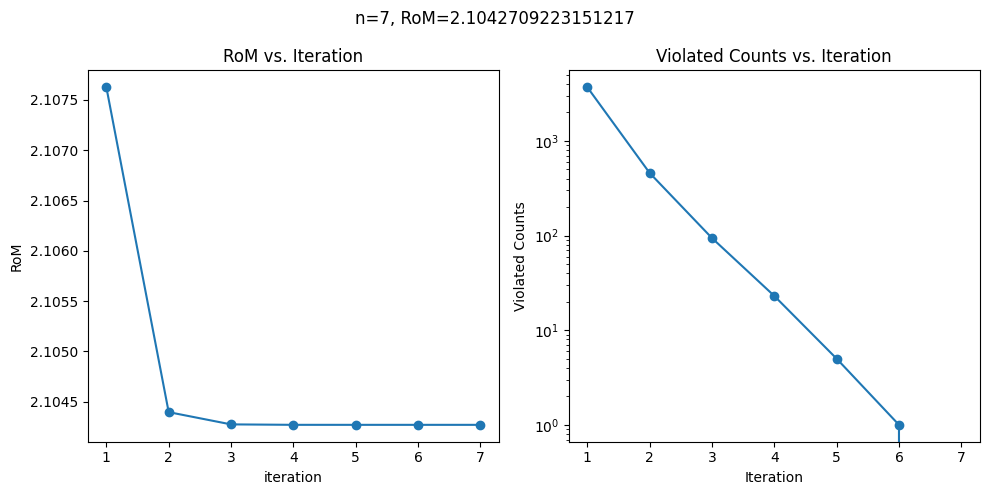

start to calculate with C++
[start] n_qubit: 7 K: 0.0000000000
init topK_value: 0.8910983743

 chunk_id = 39 | expected remain time = 0[h] 01[m] 22[s] | topK = 0.9999999999 | vt.sz() = 0
 chunk_id = 79 | expected remain time = 0[h] 01[m] 15[s] | topK = 0.9999999999 | vt.sz() = 0
 chunk_id = 119 | expected remain time = 0[h] 01[m] 04[s] | topK = 0.9999999999 | vt.sz() = 0
 chunk_id = 159 | expected remain time = 0[h] 00[m] 54[s] | topK = 0.9999999999 | vt.sz() = 0
 chunk_id = 199 | expected remain time = 0[h] 00[m] 45[s] | topK = 0.9999999999 | vt.sz() = 0
 chunk_id = 239 | expected remain time = 0[h] 00[m] 35[s] | topK = 0.9999999999 | vt.sz() = 0
 chunk_id = 279 | expected remain time = 0[h] 00[m] 26[s] | topK = 0.9999999999 | vt.sz() = 0
 chunk_id = 319 | expected remain time = 0[h] 00[m] 17[s] | topK = 0.9999999999 | vt.sz() = 0
 chunk_id = 359 | expected remain time = 0[h] 00[m] 08[s] | topK = 0.9999999999 | vt.sz() = 0
 chunk_id = 399 | expected remain time = 0[h] 00[m] 00[s] | to

(2.1042709223151217,
 <16384x520854 sparse matrix of type '<class 'numpy.int32'>'
 	with 66669312 stored elements in Compressed Sparse Column format>,
 array([ 8.15062933e-14,  5.28113921e-14,  6.80237536e-14, ...,
        -1.07941305e-07,  4.42736545e-06, -2.27785628e-08]),
 array([-0.0487267 , -0.00210664,  0.0242614 , ...,  0.01364905,
         0.00934564,  0.01338041]))

<Figure size 640x480 with 0 Axes>

In [6]:
def vis_hist(n, RoM, RoM_hist, violations_hist):
    print(f"{n=}")
    print(f"{RoM=}")
    print(f"{RoM_hist=}")
    print(f"{violations_hist=}")
    assert len(RoM_hist) == len(violations_hist)
    it = list(range(1, len(RoM_hist) + 1))
    fig = plt.figure(figsize=(10, 5))
    ax1 = plt.subplot(1, 2, 1)
    ax1.plot(it, RoM_hist, "o-")
    ax1.set_xlabel("iteration")
    ax1.set_ylabel("RoM")
    ax1.set_title("RoM vs. Iteration")
    ax2 = plt.subplot(1, 2, 2)
    ax2.plot(it, violations_hist, "o-")
    ax2.set_xlabel("Iteration")
    ax2.set_ylabel("Violated Counts")
    ax2.set_yscale("log")
    ax2.set_title("Violated Counts vs. Iteration")
    fig.suptitle(f"{n=}, {RoM=}")
    plt.tight_layout()
    plt.show()


def main(n, K, do_back_up):
    verbose: bool = True
    rho_vec = make_random_quantum_state("mixed", n, seed=0)
    eps = 1e-10
    discard_current_threshold = 0.8
    iter_max = 100

    t0 = time.perf_counter()

    if not os.path.exists("CG_cur_A_1.npz"):
        cur_A = get_topK_botK_Amat(n, rho_vec, K, is_dual=False, is_random=False)
        cur_A = scipy.sparse.hstack([cur_A, generators_to_Amat(n, cover_states(n))])

    RoM_hist = []
    violations_hist = []
    last_dual = None
    got_Amat = None
    ret = None
    for i in range(1, iter_max + 1):
        if do_back_up:
            if not os.path.exists(f"CG_cur_A_{i}.npz"):
                scipy.sparse.save_npz(f"CG_cur_A_{i}", cur_A)

        if False:
            cur_A = scipy.sparse.load_npz(f"CG_cur_A_{i}.npz")
            RoM = backup_RoMs[i - 1]
            coeff = np.load(f"CG_coeff_{i}.npz")["arr_0"]
            dual = np.load(f"CG_dual_{i}.npz")["arr_0"]
        else:
            RoM, coeff, dual = calculate_RoM_custom(
                cur_A,
                rho_vec,
                verbose=verbose,
                method="gurobi",
                return_dual=True,
                crossover=False,
            )
        print(f"turn {i}: RoM:{RoM}")
        RoM_hist.append(RoM)

        if do_back_up:
            if not os.path.exists(f"CG_RoM_hist_1_{i}.npz"):
                np.savez(f"CG_RoM_hist_1_{i}", RoM_hist)
            if not os.path.exists(f"CG_violations_hist_1_{i}.npz"):
                np.savez(f"CG_violations_hist_1_{i}", violations_hist)
            if not os.path.exists(f"CG_dual_{i}.npz"):
                np.savez(f"CG_dual_{i}", dual)
            if not os.path.exists(f"CG_coeff_{i}.npz"):
                np.savez(f"CG_coeff_{i}", coeff)

        if False:
            got_Amat = scipy.sparse.load_npz(f"CG_got_Amat_{i}.npz")
            last_dual = np.load(f"CG_last_dual_{i}.npz")["arr_0"]
        else:
            if got_Amat is None:
                got_Amat = get_topK_botK_Amat(n, dual, K, is_dual=True, is_random=False)
                last_dual = dual
            else:
                assert last_dual is not None
                last_dual_dots = np.abs(last_dual.T @ got_Amat)
                print(f"dual diff: {np.sum(np.abs(dual - last_dual))}")
                if np.min(last_dual_dots) + np.sum(np.abs(dual - last_dual)) < 1.0:
                    print("(pass the got_Amat update)")
                else:
                    got_Amat = get_topK_botK_Amat(
                        n, dual, K, is_dual=True, is_random=False
                    )
                    last_dual = dual

        dual_dots = np.abs(dual.T @ got_Amat)
        dual_violated_indices = dual_dots > 1 + eps
        indices = np.where(dual_violated_indices)[0]
        extra_Amat = got_Amat[:, indices]
        violations_hist.append(extra_Amat.shape[1] if np.min(dual_dots) < 1 else np.nan)
        if verbose:
            print(
                f"# of violation: {extra_Amat.shape[1]}",
                "and more" if np.min(dual_dots) >= 1 else "",
            )
        if extra_Amat.shape[1] == 0:
            ret = (RoM, cur_A, coeff, dual)
            break

        if do_back_up:
            if not os.path.exists(f"CG_RoM_hist_2_{i}.npz"):
                np.savez(f"CG_RoM_hist_2_{i}", RoM_hist)
            if not os.path.exists(f"CG_violations_hist_2_{i}.npz"):
                np.savez(f"CG_violations_hist_2_{i}", violations_hist)
            if not os.path.exists(f"CG_last_dual_{i}.npz"):
                np.savez(f"CG_last_dual_{i}", last_dual)
            if not os.path.exists(f"CG_got_Amat_{i}.npz"):
                scipy.sparse.save_npz(f"CG_got_Amat_{i}", got_Amat)

        nonbasic_indices = np.abs(coeff) > eps
        critical_indices = np.abs(dual @ cur_A) >= discard_current_threshold
        remain_indices = np.logical_or(nonbasic_indices, critical_indices)
        cur_A = scipy.sparse.hstack((cur_A[:, remain_indices], extra_Amat))

    if ret is None:
        assert False, "failed CG"
    RoM, cur_A, coeff, dual = ret
    print(f"calculation finished: RoM:{RoM} in {time.perf_counter() - t0} sec")

    if do_back_up:
        np.savez(f"CG_RoM_hist_final", RoM_hist)
        np.savez(f"CG_violations_hist_final", violations_hist)

    vis_hist(n, RoM, RoM_hist, violations_hist)

    max_violated_matrix = get_topK_botK_Amat(n, dual, 0, is_dual=True, is_random=False)
    should_be_rho_vec = cur_A @ coeff
    print(f"{should_be_rho_vec=} / {rho_vec=}")
    should_be_less_1 = np.abs(dual.T @ max_violated_matrix)
    print(f"{should_be_less_1=}")
    assert np.allclose(cur_A @ coeff, rho_vec)
    assert np.max(should_be_less_1) <= 1 + eps

    if do_back_up:
        np.savez(f"finished", np.array([7, 7, 7]))

    return RoM, cur_A, coeff, dual


# n, K = 5, 0.01
# n, K = 6, 0.001
n, K = 7, 0.00001
# n, K = 8, 0.00000001
main(n, K, False)

## vis


In [3]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_theme("paper")
rc = {"mathtext.fontset": "stix"}
plt.rcParams.update(rc)
sns.set(font_scale=1.25, font="Times New Roman")


def visualize_multiple_Amat(n_qubit, RoMs, violations):
    fig = plt.figure(figsize=(6.5, 5))
    ax1 = plt.subplot(1, 2, 1)
    ax2 = plt.subplot(1, 2, 2)
    # plot RoMs to ax1 with seaborn
    sns.lineplot(x=list(range(1, len(RoMs) + 1)), y=RoMs, ax=ax1, marker="o")
    ax1.set_xlabel("Iteration", fontsize=25)
    ax1.set_ylabel("RoM", fontsize=25)
    ax1.set_xticks(list(range(1, len(RoMs) + 1)))
    ax1.set_title(f"$n = {n_qubit}$", fontsize=25)
    sns.lineplot(
        x=list(range(1, len(violations) + 1)),
        y=1 + np.array(violations),
        ax=ax2,
        marker="o",
    )
    ax2.set_xlabel("Iteration", fontsize=25)
    ax2.set_ylabel("1 + violation count", fontsize=25)
    ax2.set_xticks(list(range(1, len(violations) + 1)))
    ax2.set_title(f"$n = {n_qubit}$", fontsize=25)
    ax2.set_yscale("log")
    if n_qubit == 7:
        ax2.set_yticks([10**i for i in range(0, 3 + 1)])
    elif n_qubit == 8:
        ax2.set_yticks([10**i for i in range(0, 12 + 1, 3)])
    else:
        assert False
    fig.suptitle("(a)" if n_qubit == 7 else "(b)", fontsize=25, y=0.85, x=0.05)
    plt.tight_layout()
    plt.savefig(f"CG_{n_qubit}.pdf", bbox_inches="tight")
    plt.close()


if __name__ == "__main__":
    n_qubit = 7
    RoMs = [
        2.1076267438064518,
        2.1043971888144997,
        2.104275447697977,
        2.1042710427874636,
        2.1042709244886106,
        2.1042709304733167,
        2.1042709223151217,
    ]
    violations = [3687, 458, 94, 23, 5, 1, 0]
    visualize_multiple_Amat(n_qubit, RoMs, violations)

    n_qubit = 8
    RoMs = [
        2.6543700909128205,
        2.595668878086846,
        2.563650057525814,
        2.5538644409534434,
        2.552819158901894,
        2.55273959867054,
        2.552735559869347,
        2.5527353974360514,
        2.5527353925165244,
        2.5527353962689014,
    ]
    violations = [1114667212982, 1661481, 70290, 11363, 2416, 567, 125, 15, 4, 0]
    visualize_multiple_Amat(n_qubit, RoMs, violations)